# Objective
Evaluate interpretation and evaluation of hazard ratios/hazard rates with bart vs cox

In [1]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines

# Tasks
1. Identify how the HR of the cox model relates to the Weibull model
2. Identify how the HZ of bart relates to the HZ of cox
3. Identify how HR can mislead severity based on rarity and censoring
4. Identify how BART can specify HR


## Identify how the HR of cox relates to weibull model

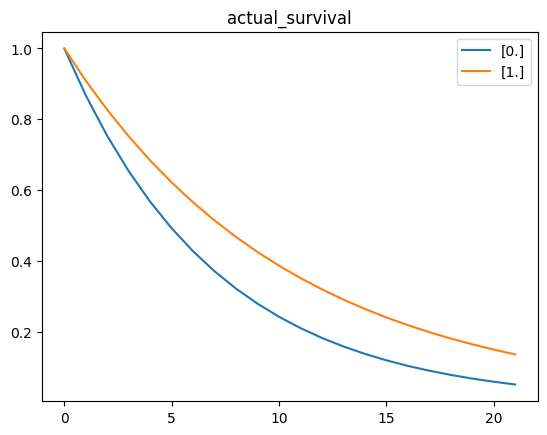

cens_calc: 0.5900000000000001     
t_mean: 4.14     
t_max: 22.0


In [2]:
OUTPUTS = "outputs"
ALPHA = 1
LAMBDA = "np.exp(2 + 0.4*x_mat[:,0])"
TRAIN_CSV = "outputs/train.csv"
RBART_CSV = "outputs/rbart_surv.csv"
N = 100
# T = 30
X_VARS = 1
CENS_SCALE = 5# 40
CENS_IND = False

sv_mat, x_mat, lmbda, a, tlat, cens, t_event, status, T = ssf.sim_surv(
                N=N, 
                x_vars=X_VARS,
                a = ALPHA,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = True,
                err_ind = False)


x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
event_calc, cens_calc = ssf.get_status_perc(status) 
t_mean, t_max = ssf.get_event_time_metric(t_event)
train = ssf.get_train_matrix(x_mat, t_event, status)
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

In [12]:
# exp model

t = np.arange(1,25,1)

x = np.array([0])
a = 1
B = 1.2
# lmbda = np.exp(0.1+ x[0] * B)
lmbda = .2


# hz = np.power(lmbda,a) * a * np.power(t, a-1) 
# hz
ht = np.outer(lmbda, a * np.power(np.outer(lmbda, t), a-1))

st = np.exp(np.power(-1 * lmbda * t, a))
ft = ht * st
print(np.cumsum(ft))
print(1-np.cumsum(ft))
print(st)
print(np.outer(lmbda, t))

[0.16374615 0.29781016 0.40757249 0.49743828 0.57101417 0.63125301
 0.6805724  0.72095171 0.75401148 0.78107854 0.80323917 0.82138276
 0.83623748 0.84839949 0.85835691 0.86650935 0.873184   0.87864874
 0.8831229  0.88678603 0.88978514 0.89224061 0.89425098 0.89589693]
[0.83625385 0.70218984 0.59242751 0.50256172 0.42898583 0.36874699
 0.3194276  0.27904829 0.24598852 0.21892146 0.19676083 0.17861724
 0.16376252 0.15160051 0.14164309 0.13349065 0.126816   0.12135126
 0.1168771  0.11321397 0.11021486 0.10775939 0.10574902 0.10410307]
[0.81873075 0.67032005 0.54881164 0.44932896 0.36787944 0.30119421
 0.24659696 0.20189652 0.16529889 0.13533528 0.11080316 0.09071795
 0.07427358 0.06081006 0.04978707 0.0407622  0.03337327 0.02732372
 0.02237077 0.01831564 0.01499558 0.01227734 0.01005184 0.00822975]
[[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6
  3.8 4.  4.2 4.4 4.6 4.8]]


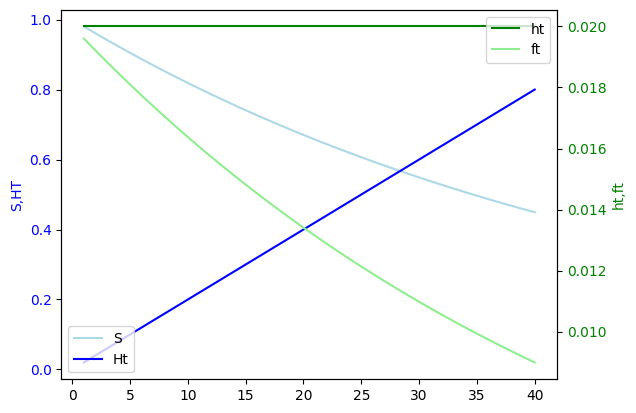

In [68]:
# exponential model

# h(t) = lmbda

# lmbda = exp(X*B)

# H(t) = intgrl_0_t(h(t) dt) == lmbda*t

# S(t) = exp[-H(t)] = exp(-lmbda*t)
# S_i(t) = exp(-exp(X_i*B)*t)

# f(t) = h(t)S(t) = lmbda*exp(-lmbda*t)


t = np.arange(1,41,1)
ht = 0.02
Ht = np.cumsum(np.repeat(ht,40))
S = np.exp(-ht*t)
ft = ht * S
# print(S)
# print(ft)



# plot survival
fig, ax1 = plt.subplots()
ax1.plot(t, S, label="S", color="lightblue")
ax1.plot(t, Ht, label="Ht", color="blue")
ax1.set_ylabel("S,HT", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.legend(loc="lower left")
ax2 = ax1.twinx()
ax2.plot(t, np.repeat(ht,40), label="ht", color="green")
ax2.plot(t,ft, label="ft", color="lightgreen")
ax2.set_ylabel("ht,ft", color="green")
ax2.tick_params(axis="y", labelcolor="green")
ax2.legend(loc="upper right")

hazard_1 [[0.44932896]
 [0.22313016]]
hazard_2 [[0.10025884]
 [0.04978707]]
hazard ratio calculated from hazard rate direct: [2.01375271]
hazard ratio from exp coefficient 2.0137527074704766
hazard ratio calculated from hazard rate direct: [2.01375271]
hazard ratio from exp coefficient 2.0137527074704766


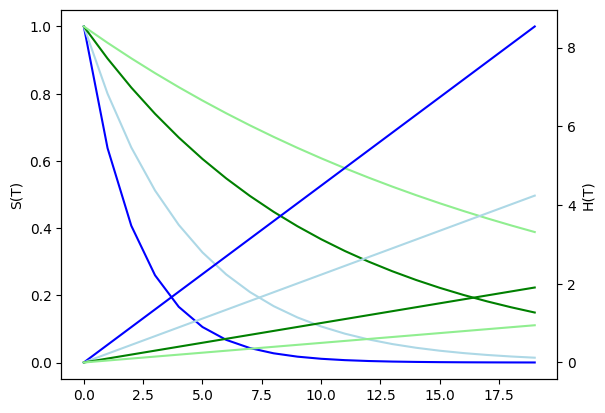

In [190]:
# Hazard Ratios

# h(t) = lmbda
# lmbda_i = exp(X_i*B)
# h_i(t) = exp(B_0)* exp(X_i*B)
# HR = exp(B_k)
# HR_k = (h(t)|X_k + d )/ (h(t)|X_k)  = exp(d*B_k)
# HR_i/j = (exp(X_i*B))
PRINT_ARRAY = False

X = np.array([[1,1],[1,0]])
B = np.array([-1.5, .7])
B2 = np.array([-3, .7])
# lmbda = np.dot(X,B)
lmbda = np.prod(np.exp(X*B),1).reshape(2,1)
lmbda2 = np.prod(np.exp(X*B2),1).reshape(2,1)

# h(t) = lmbda given an exponential model
ht = lmbda
ht2 = lmbda2
if True:
    print(f"hazard_1 {ht}")
    print(f"hazard_2 {ht2}")

# set time
t = np.arange(0,20,1)

# Get Cumulative Hazard
# H(t) = I_0_t(h(t)dt) = lmbda*t
H = ht*t
H2 = ht2*t

if PRINT_ARRAY:
    print(f"Cumulative Hazard1 {H}")
    print(f"Cumulative Hazard2 {H2}")

# S_i(t) = exp(-exp(X_i*B)*t) = exp(-ht*t) = exp(-H(t))
S = np.exp(-1*H)
S2 = np.exp(-1*H2)

if PRINT_ARRAY:
    print(f"S_1 {S}")
    print(f"S_2 {S2}")

# Plot Survival and Hazard
fig, ax1 = plt.subplots()
ax1.plot(t, S[0], color = "blue")
ax1.plot(t, S[1], color = "lightblue")
ax1.plot(t, S2[0], color = "green")
ax1.plot(t, S2[1], color = "lightgreen")
ax1.set_ylabel("S(T)")
ax1.tick_params(axis="y")
ax2 = ax1.twinx()
ax2.plot(t, H[0], label="ht", color="blue")
ax2.plot(t, H[1], label="ft", color="lightblue")
ax2.plot(t, H2[0], label="ht", color="green")
ax2.plot(t, H2[1], label="ft", color="lightgreen")
ax2.set_ylabel("H(T)")
ax2.tick_params(axis="y")
# ax2.legend(loc="upper right")


# Hazard Ratio is cacluated as the exp(Coef) or by the ht
print(f"hazard ratio calculated from hazard rate direct: {ht[0]/ht[1]}")
print(f"hazard ratio from exp coefficient {np.exp(B[1])}")
print(f"hazard ratio calculated from hazard rate direct: {ht2[0]/ht2[1]}")
print(f"hazard ratio from exp coefficient {np.exp(B2[1])}")


# plt.plot()

In [203]:
# S2[0]/S2[1]
# H(t) = I_0_t(h(t)dt) = lmbda*t
# Basically we are viewing how the hazard rate become the Survival function through the Cumulative Hazard
def get_H_diff(H):
    H_diff = np.zeros_like(H)
    for idx, i in enumerate(H):
        if idx < H.shape[0]-1:
            H_diff[idx] = i - H[idx+1]
    return H_diff

H_diff10 = get_H_diff(H[0])
H_diff11 = get_H_diff(H[1])
H_diff20 = get_H_diff(H2[0])
H_diff21 = get_H_diff(H2[1])

print(H_diff10)
print(H_diff11)
print(H_diff20)
print(H_diff21)

[-0.44932896 -0.44932896 -0.44932896 -0.44932896 -0.44932896 -0.44932896
 -0.44932896 -0.44932896 -0.44932896 -0.44932896 -0.44932896 -0.44932896
 -0.44932896 -0.44932896 -0.44932896 -0.44932896 -0.44932896 -0.44932896
 -0.44932896  0.        ]
[-0.22313016 -0.22313016 -0.22313016 -0.22313016 -0.22313016 -0.22313016
 -0.22313016 -0.22313016 -0.22313016 -0.22313016 -0.22313016 -0.22313016
 -0.22313016 -0.22313016 -0.22313016 -0.22313016 -0.22313016 -0.22313016
 -0.22313016  0.        ]
[-0.10025884 -0.10025884 -0.10025884 -0.10025884 -0.10025884 -0.10025884
 -0.10025884 -0.10025884 -0.10025884 -0.10025884 -0.10025884 -0.10025884
 -0.10025884 -0.10025884 -0.10025884 -0.10025884 -0.10025884 -0.10025884
 -0.10025884  0.        ]
[-0.04978707 -0.04978707 -0.04978707 -0.04978707 -0.04978707 -0.04978707
 -0.04978707 -0.04978707 -0.04978707 -0.04978707 -0.04978707 -0.04978707
 -0.04978707 -0.04978707 -0.04978707 -0.04978707 -0.04978707 -0.04978707
 -0.04978707  0.        ]


Connect with the wiebull distribution


In [912]:
def sim_surv(N=100, 
            x_vars = 1, 
            lambda_f=None, 
            a=2, 
            alpha_f = None, 
            seed=999, 
            cens_ind = True,
            cens_scale = 20,
            err_ind = False):
    # np.random.seed(seed)

    x_mat = np.zeros((N, x_vars))
    for x in np.arange(x_vars):
        x1 = sp.bernoulli.rvs(.5, size = N)
        x_mat[:,x] = x1
    # calculate lambda
    
    # set lambda
    if lambda_f is None:
        lmbda = np.exp(2 + 0.3*(x_mat[:,0] + x_mat[:,1]) + x_mat[:,2])
    else:
        lmbda = eval(lambda_f)
    
    # set alpha if specified
    if alpha_f is None:
        a = np.repeat(a, N)
    else:
        a = eval(alpha_f)

    # add error
    if err_ind:
        error = sp.norm.rvs(0, .5, size = N)
        lmbda=lmbda + error

    
    # get the event times
    tlat = np.zeros(N)
    for idx, l in enumerate(lmbda):
        # generate event times 
        # unif = np.random.uniform(size=1, low=0.4, high=0.5)
        unif = np.random.uniform(size=1)
        # print(unif)
        # ev = lmbda[idx] * np.power((-1 * np.log(unif)), 1/a[idx])
        # ev = -1 * np.log(np.power(unif, 1/a[idx])) / l
        # break
        ev = np.power(-1*np.log(unif), 1/a[idx]) / l
        # print(ev)
        # break
        tlat[idx] = ev
    
    if cens_ind:
        # censor
        cens = np.ceil(np.random.exponential(size = N, scale = cens_scale))

        # min cen and surv event
        t_event  = np.minimum(cens, np.ceil(tlat))
        status = (tlat <= cens) * 1
    else:
        cens=np.zeros(N)
        t_event = np.ceil(tlat)
        status = np.ones(N)
    
    # get max event time
    T = int(t_event.max())
    # get time series
    t = np.linspace(0,T, T)
    # t = np.arange(0,20,1)

    
    # get surv curve true
    sv_mat = np.zeros((N, t.shape[0]))
    hz_mat = np.zeros((N, t.shape[0]))
    for idx, l in enumerate(lmbda):
        # sv = np.exp(-1 * np.power((t/l), a[idx])) # old way
        # sv = np.power(np.exp(-1*l*t), a[idx]) # new
        sv = np.exp(-1 * np.power((l*t), a[idx])) # new
        hz = (l*a[idx]) * np.power(l*t, a[idx]-1)
        # sv = np.exp(-1* np.cumsum(hz))
        # print(hz1)
        # print(np.array(l*t))
        # hz2 = np.exp(l*t, (a[idx] - 1))
        # print(hz2)
        sv_mat[idx,:] = sv
        hz_mat[idx,:] = hz
         
        

    return sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T




In [914]:

# aaa = -3
# ppp = 1
# t = 40
# print(np.exp(aaa) * np.arange(0,t,1))
# print(np.power(np.exp(aaa) * np.arange(0,t,1), ppp))
# print(np.exp(-1*np.power(np.exp(aaa) * np.arange(0,t,1), ppp)))


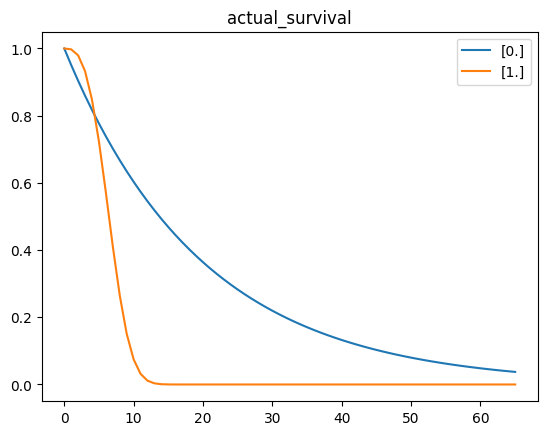

cens_calc: 0.0     
t_mean: 13.91     
t_max: 66.0


In [918]:
OUTPUTS = "outputs"
ALPHA = 1
ALPHA_F = "1 + 2*x_mat[:,0]"
# ALPHA_F = "1+ 5*x_mat[:,0]"

LAMBDA = "np.exp(-3 + 1*x_mat[:,0])"
TRAIN_CSV = "outputs/train.csv"
RBART_CSV = "outputs/rbart_surv.csv"
N = 100
# T = 30
X_VARS = 1
CENS_SCALE = 5# 40
CENS_IND = False

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = sim_surv(
                N=N, 
                x_vars=X_VARS,
                a = ALPHA,
                alpha_f=ALPHA_F,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = False,
                err_ind = False)

# T = 20
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
event_calc, cens_calc = ssf.get_status_perc(status) 
t_mean, t_max = ssf.get_event_time_metric(t_event)
train = ssf.get_train_matrix(x_mat, t_event, status)
title = "actual_survival"

x_unique = np.unique(x_mat, return_index=True)
sv_unique = sv_mat[x_unique[1],:]
ssf.plot_sv(x_mat, sv_unique, T, title=title, save = False, show=True, dir=OUTPUTS)


print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

(array([ 4.,  5.,  3.,  9.,  6., 10.,  1.,  6.,  0.,  2.]),
 array([ 2. ,  3.1,  4.2,  5.3,  6.4,  7.5,  8.6,  9.7, 10.8, 11.9, 13. ]),
 <BarContainer object of 10 artists>)

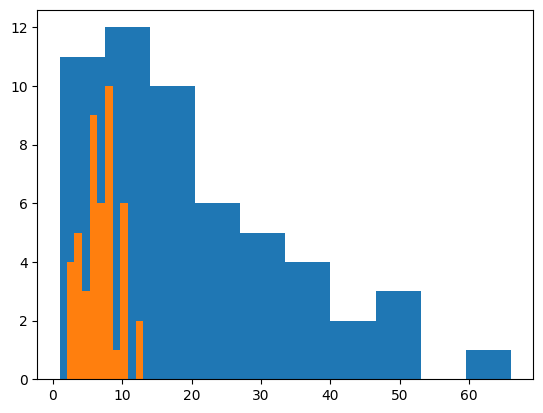

In [948]:
# plt.plot(train.)
x0 = train[train["X0"] == 0]
x1 = train[train["X0"] == 1]

plt.hist(x0["time"], w)
plt.hist(x1["time"])




Avgerage hz_0: 0.049787068367863944
Average hz_1: 11.047894081367586
Average HR 221.90288449477518


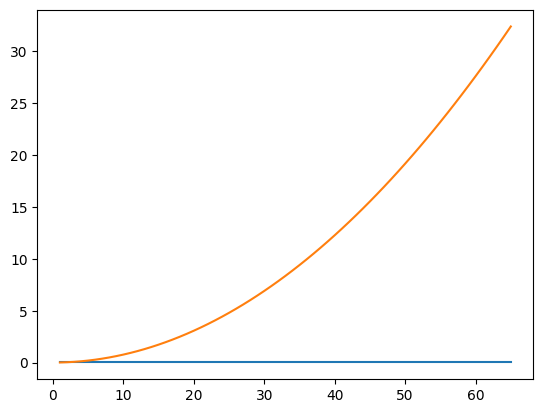

In [949]:
# Hazard TRUE
x_unique = np.unique(x_mat, return_index=True)
hz_unique = hz_mat[x_unique[1],1:]

print(f"Avgerage hz_0: {hz_unique[0].mean()}")
print(f"Average hz_1: {hz_unique[1].mean()}")
print(f"Average HR {(hz_unique[1]/hz_unique[0]).mean()}")

plt.plot(np.arange(1,T,1), hz_unique[0])
plt.plot(np.arange(1,T,1), hz_unique[1])

<lifelines.CoxPHFitter: fitted with 100 total observations, 0 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 100
   partial log-likelihood = -342.53
         time fit was run = 2023-08-24 21:08:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
X0          1.74       5.68       0.28             1.19             2.29                 3.27                 9.85

            cmp to    z      p   -log2(p)
covariate                                
X0            0.00 6.18 <0.005      30.57
---
Concordance = 0.65
Partial AIC = 687.05
log-likelihood ratio test = 42.42 on 1 df
-log2(p) of ll-ratio test = 33.66

Text(52.8, 0.4, 'True Ave HR 218.54')

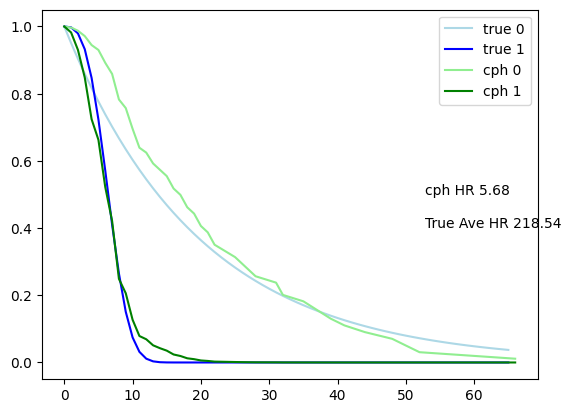

In [921]:
# get the plot for survival true
x_unique = np.unique(x_mat, return_index=True)
sv_unique = sv_mat[x_unique[1],:]

# lifelines
cphl = lifelines.CoxPHFitter()
cphl.fit(train, duration_col="time", event_col="status")
cphl.print_summary()
cphl_pred = cphl.predict_survival_function(pd.DataFrame(x_out, columns= ["X0"]))
cphl_pred.columns=["a", "b"]
cdhl_pred = pd.concat([pd.DataFrame([[1,1]], columns = ["a","b"]),cphl_pred], axis=0)

# plot
plt.plot(np.arange(0,T,1), sv_unique[0], color= "lightblue", label="true 0")
plt.plot(np.arange(0,T,1), sv_unique[1], color = "blue", label="true 1")
plt.plot(cdhl_pred.index, cdhl_pred["a"], label = "cph 0", color="lightgreen")
plt.plot(cdhl_pred.index, cdhl_pred["b"], label = "cph 1", color = "green")
plt.legend()

# get cphl HR
cphl_expco = cphl.summary["exp(coef)"]
plt.text(T-T/5,.5,f"cph HR {np.round(cphl_expco[0],2)}")


# get TRUE HR
hz_unique = hz_mat[x_unique[1],:]
true_HR = np.round(hz_unique[1].mean()/hz_unique[0].mean(),2)
plt.text(T-T/5,.4, f"True Ave HR {true_HR}")




In [951]:
hz_unique = hz_mat[x_unique[1],:]
true_HR = np.round(hz_unique[1]/hz_unique[0],2)
true_HR.mean()
# plt.text(T-T/5,.4, f"True Ave HR {true_HR}")


218.5407575757576

Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 51 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f, y_pred]


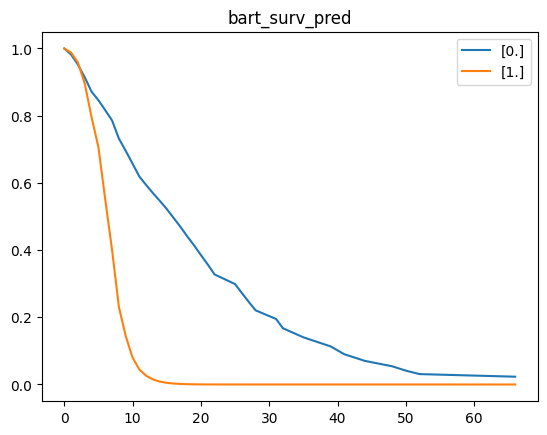

In [922]:
# BART
M = 200 # number of trees
DRAWS = 200
TUNE = 200
CORES = 4

y_sk = ssf.get_y_sklearn(status, t_event)
x_sk = train.iloc[:,2:]


# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk)
# b_te_t, b_te_x = surv_pre_test(x_sk, y_sk)
b_te_x = ssf.get_bart_test(x_out, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))
# model bart

with pm.Model() as bart:
    x_data = pm.MutableData("x", b_tr_x)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M)
    z = pm.Deterministic("z", f + off)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
    bdata = pm.sample(random_seed=2, draws=200, tune = 200, cores=4)

with bart:
# pm.set_data({"x":pd.DataFrame(test_x), "off":off_test})
    pm.set_data({"x":pd.DataFrame(b_te_x)})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# transform to survival
bart_sv_fx = ssf.get_sv_fx(pp, x_out)
# bart_svt
bart_sv_t = np.unique(b_tr_t)

# add a time 0 with prob 1 
bart_sv_t = np.concatenate([np.array([0]), bart_sv_t])
bart_sv_val = [np.concatenate([np.array([1]), sv]) for sv in bart_sv_fx]

# log artif plot curves
# title = "bart_surv_pred"
# ssf.plot_sv(x_mat, bart_sv_val, t=bart_sv_t, title=title, save=False, show=True, dir="outputs")

# get metrics rmse, bias
# rsf_rmse, rsf_bias, t_quant = ssf.get_metrics( f_t = rsf_sv_val, f = sv_mat[x_idx], T = rsf_sv_t[rsf_sv_t <T])



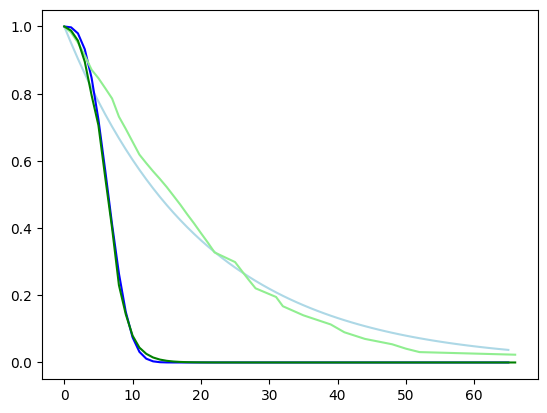

In [925]:
plt.plot(np.arange(0,T,1), sv_unique[0], color= "lightblue", label="true 0")
plt.plot(np.arange(0,T,1), sv_unique[1], color = "blue", label="true 1")
plt.plot(bart_sv_t, bart_sv_val[0], color = "lightgreen", label="bart 1")
plt.plot(bart_sv_t, bart_sv_val[1], color = "green", label="bart 1")



In [947]:

cph_sv_val = [cdhl_pred["a"].to_numpy(), cdhl_pred["b"].to_numpy()]
cph_sv_t = cdhl_pred.index
cph_rmse, cph_bias, t_quant = ssf.get_metrics( f_t = cph_sv_val, f = sv_mat[x_idx], T = cph_sv_t[cph_sv_t < T])

bart_rmse, bart_bias, t_quant = ssf.get_metrics(f_t = bart_sv_val, f = sv_mat[x_idx], T = bart_sv_t[bart_sv_t < T])

print(cph_rmse)
print(cph_bias)
print(bart_rmse)
print(bart_bias)

[[0.0685 0.0951 0.0429 0.0126 0.0062]]
[[ 0.0172  0.0889  0.0359 -0.0088 -0.0044]]
[[0.0372 0.0432 0.0271 0.0427 0.006 ]]
[[ 0.0132  0.0268  0.0196 -0.0302 -0.0042]]
